## Part 1: Single Trajectory Example
Let's run a single simulation to see how it works.

### Setup Simulation Parameters

In [1]:
import torch
import numpy as np
import math
from tqdm import tqdm
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
from solver import *

--- 1. Simulation Parameters ---

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {DEVICE}")

N_RES = 64 # Resolution (N x N grid) 
DOMAIN_SIZE = np.pi # Physical size of the domain 
BATCH_SIZE = 1 # We'll run one simulation

VISC = 1e-3 # Viscosity 
T_TOTAL = 30.0 # Total simulation time 
DT = 1e-3 # Time step 
N_SNAPSHOTS = 300 # Number of snapshots to save

Using device: cuda


--- 2. Generate Initial Condition (Random) ---

In [3]:
grf_generator = GaussianRF( size=N_RES, domain_size=DOMAIN_SIZE, device=DEVICE ) 
w0_torch = grf_generator.sample(BATCH_SIZE)

--- 3. Generate Forcing Field ---

In [4]:
t = torch.linspace(0, DOMAIN_SIZE, N_RES+1, device=DEVICE)[0:-1] 
X, Y = torch.meshgrid(t, t, indexing='ij') 
f_torch = 0.1 * (torch.cos(2 * (X+Y)) + torch.sin(2 * (X+Y))).unsqueeze(0)

print(f"Initial Vorticity w0 shape: {w0_torch.shape}") 
print(f"Forcing f shape: {f_torch.shape}")

Initial Vorticity w0 shape: torch.Size([1, 64, 64])
Forcing f shape: torch.Size([1, 64, 64])


### Run the Simulation

In [5]:
w_hist, u_hist, v_hist = solve_dns_vorticity( w0=w0_torch, f=f_torch, visc=VISC, T=T_TOTAL, delta_t=DT, record_steps=N_SNAPSHOTS, domain_size=DOMAIN_SIZE )

print("\n--- Simulation Complete ---") 
print(f"Vorticity history shape: (Batch, Time, N, N) = {w_hist.shape}") 
print(f"U-Velocity history shape: (Batch, Time, N, N) = {u_hist.shape}") 
print(f"V-Velocity history shape: (Batch, Time, N, N) = {v_hist.shape}")

Running 64x64 DNS: 100%|██████████| 30000/30000 [00:12<00:00, 2428.30it/s]


--- Simulation Complete ---
Vorticity history shape: (Batch, Time, N, N) = torch.Size([1, 300, 64, 64])
U-Velocity history shape: (Batch, Time, N, N) = torch.Size([1, 300, 64, 64])
V-Velocity history shape: (Batch, Time, N, N) = torch.Size([1, 300, 64, 64])


Let's visualize the very last snapshot of the simulation.

In [6]:
w_final = w_hist[0, -1].cpu().numpy() 
u_final = u_hist[0, -1].cpu().numpy() 
v_final = v_hist[0, -1].cpu().numpy()

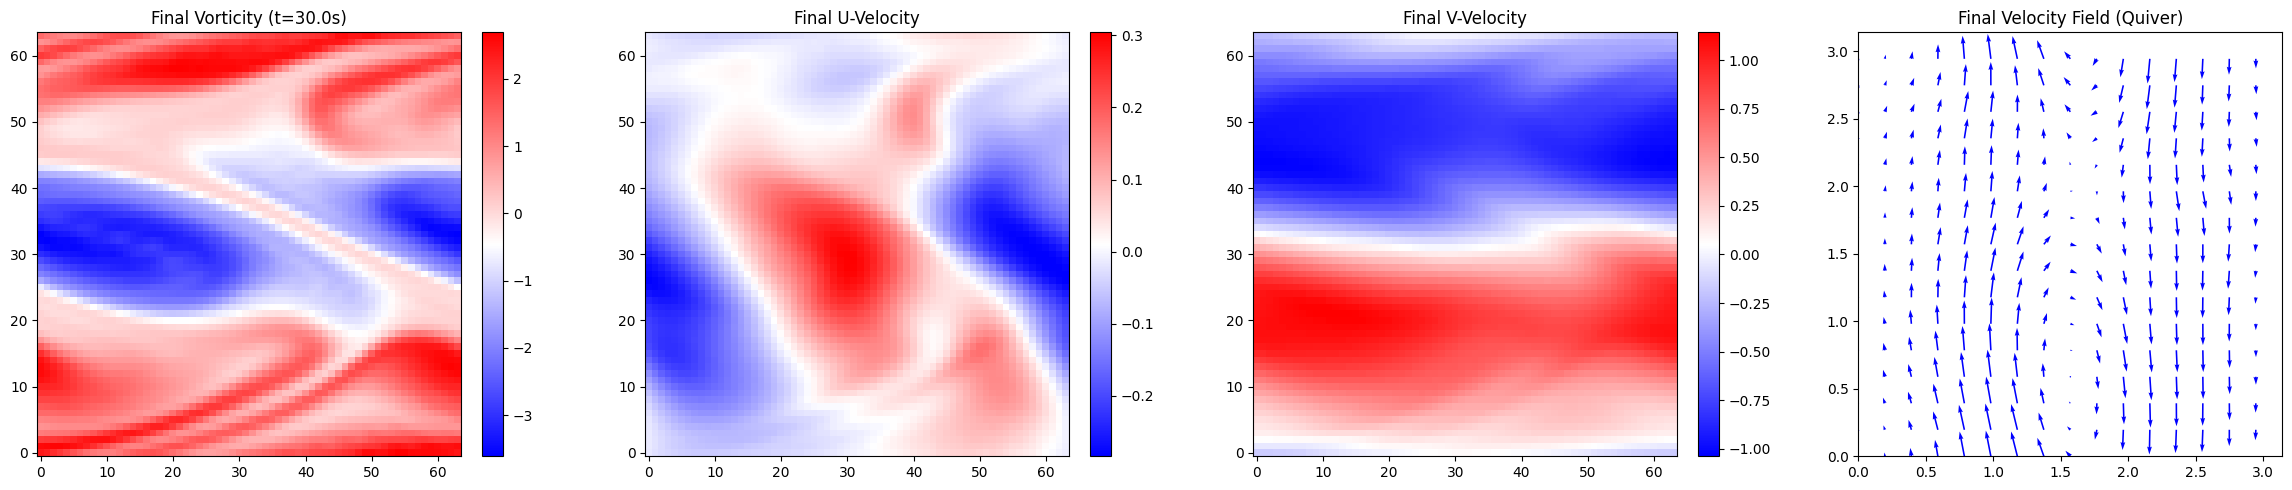

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5)) 
cbar_ax_ws = [0.08, 0.35, 0.62] # x-positions for colorbars

im0 = axes[0].imshow(w_final, cmap='bwr', origin='lower') 
axes[0].set_title(f"Final Vorticity (t={T_TOTAL:.1f}s)") 
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(u_final, cmap='bwr', origin='lower') 
axes[1].set_title("Final U-Velocity") 
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(v_final, cmap='bwr', origin='lower')
axes[2].set_title("Final V-Velocity")
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

skip = 4
im3 = axes[3].quiver(
    X[::skip, ::skip].cpu(),
    Y[::skip, ::skip].cpu(),
    u_final[::skip, ::skip],
    v_final[::skip, ::skip],
    color='blue'
)
axes[3].set_title("Final Velocity Field (Quiver)")
axes[3].set_aspect('equal')
axes[3].set_xlim(0, DOMAIN_SIZE)
axes[3].set_ylim(0, DOMAIN_SIZE)

plt.tight_layout()
plt.show()

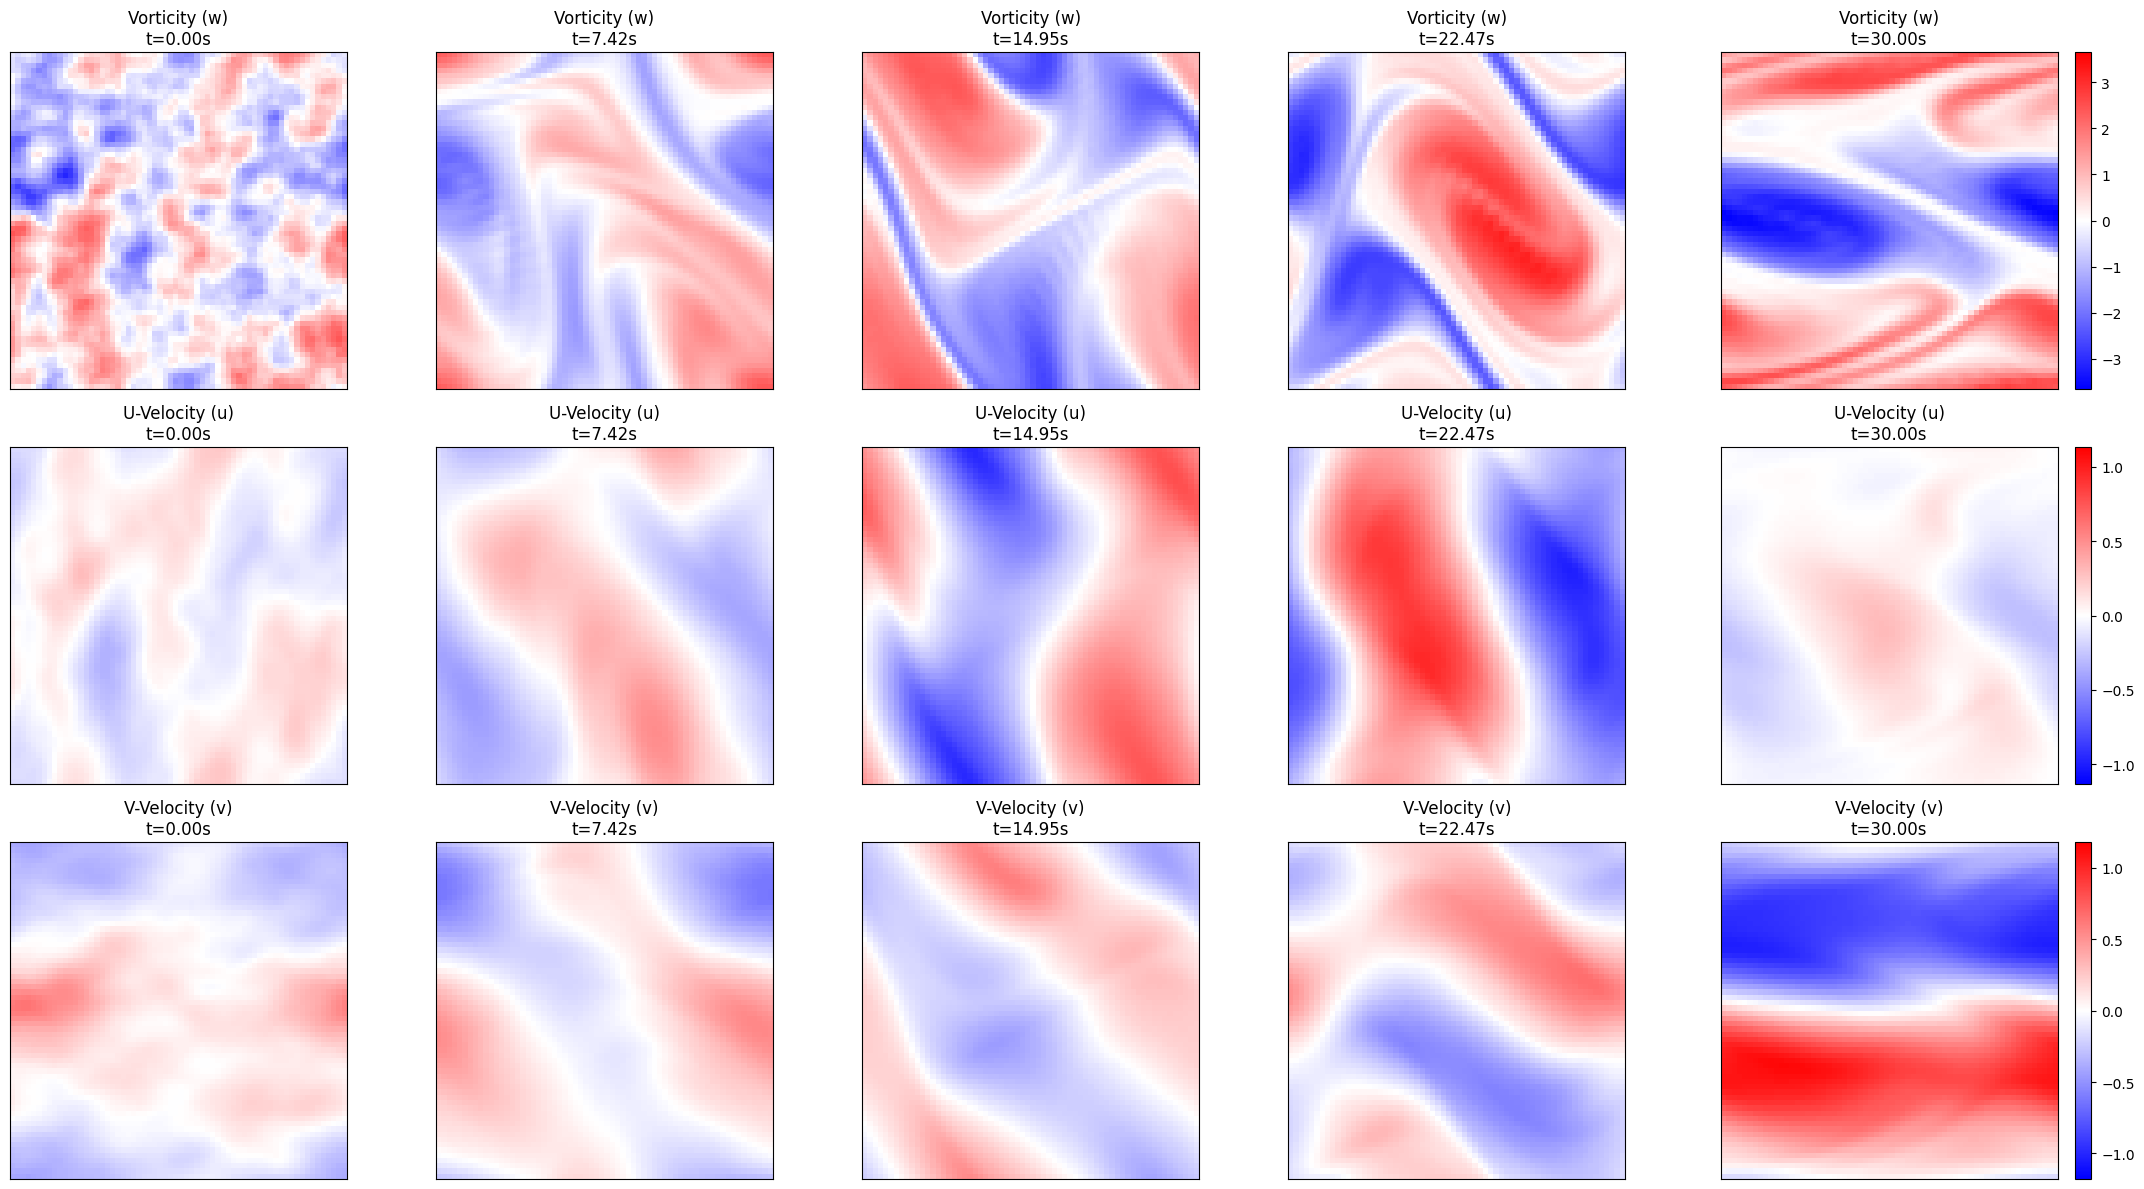

In [8]:
n_rows = 3 
n_cols = 5 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 12))

indices_to_plot = np.linspace(0, N_SNAPSHOTS - 1, n_cols, dtype=int)

data_list = [w_hist[0], u_hist[0], v_hist[0]] 
titles_list = ['Vorticity (w)', 'U-Velocity (u)', 'V-Velocity (v)']

cmaps_list = ['bwr', 'bwr', 'bwr']

for i in range(n_rows): # Loop over rows (variables) 
    data = data_list[i] 
    cmap = cmaps_list[i] 
    title_prefix = titles_list[i]
    
    # --- Set Consistent Color Limits for the whole row ---
    vmin = data.min().item()
    vmax = data.max().item()

    # If using a diverging colormap like 'bwr', it's best
    # to center it at 0.
    if cmap == 'bwr':
        abs_max = max(abs(vmin), abs(vmax))
        vmin = -abs_max
        vmax = abs_max
    # ---

    for j in range(n_cols): # Loop over columns (time points)
        ax = axes[i, j]
        idx = indices_to_plot[j]
        
        # Get the specific snapshot to plot
        field = data[idx].cpu().numpy()
        
        # Calculate the actual time for the title
        # (This works even if N_SNAPSHOTS=1)
        time_percent = (idx / (N_SNAPSHOTS - 1)) if N_SNAPSHOTS > 1 else 1.0
        time_t = time_percent * T_TOTAL
        
        # --- Plotting ---
        im = ax.imshow(field, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(f"{title_prefix}\nt={time_t:.2f}s")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add a colorbar to the last plot in each row
        if j == (n_cols - 1):
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout() 
plt.show()

A key property of this flow is that it's incompressible. 

This means the velocity field $\mathbf{u} = (u, v)$ has zero divergence:
$$\nabla \cdot \mathbf{u} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

Our solver doesn't enforce this directly, but it's a mathematical property of solving for velocity from vorticity via the streamfunction. Let's check how well it holds. We'll use the calculate_divergence function, which computes the derivatives in Fourier space for high accuracy.

In [9]:
u_final_torch = u_hist[0, -1] 
v_final_torch = v_hist[0, -1]

div_field = calculate_divergence(u_final_torch, v_final_torch, DOMAIN_SIZE)

mean_abs_div = torch.mean(torch.abs(div_field)).item()

print(f"--- Incompressibility Check ---") 
print(f"Mean Absolute Divergence: {mean_abs_div: .2e}") 
print("A value very close to zero confirms the flow is incompressible.")

--- Incompressibility Check ---
Mean Absolute Divergence:  1.23e-06
A value very close to zero confirms the flow is incompressible.


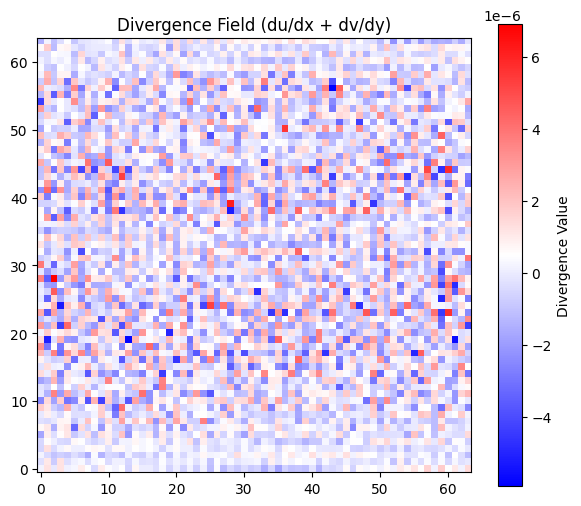

The plot should show only random numerical noise centered at 0.


In [10]:
plt.figure(figsize=(7, 6)) 
im = plt.imshow(div_field.cpu().numpy(), cmap='bwr', origin='lower') 
plt.title("Divergence Field (du/dx + dv/dy)") 
plt.colorbar(im, label="Divergence Value") 
plt.show() 
print("The plot should show only random numerical noise centered at 0.")

The Data Generation Loop

In [11]:
N_TRAJECTORIES = 20 
BATCH_SIZE = 1 # Process 1 trajectory at a time for memory safety 
T_SPINUP = 15.0 # Time to run before recording 
T_RECORD = 15.0 # Time to run while recording (Total T = 30.0) 
N_SAVE_SNAPSHOTS = 1500 # Snapshots to save during the T_RECORD phase

In [12]:
grf_gen_data = GaussianRF( size=N_RES, domain_size=DOMAIN_SIZE, device=DEVICE )

t = torch.linspace(0, DOMAIN_SIZE, N_RES+1, device=DEVICE)[0:-1] 
X, Y = torch.meshgrid(t, t, indexing='ij') 
f_base = 0.1 * (torch.cos(2 * (X+Y)) + torch.sin(2 * (X+Y))).unsqueeze(0)

print(f"--- Data Generation Plan ---") 
print(f"Will generate {N_TRAJECTORIES} trajectories.") 
print(f"Each will be {N_RES}x{N_RES} resolution.") 
print(f"Each will spin up for {T_SPINUP}s.") 
print(f"Each will record for {T_RECORD}s, saving {N_SAVE_SNAPSHOTS} snapshots.") 
print(f"Total snapshots to collect: {N_TRAJECTORIES * N_SAVE_SNAPSHOTS}")

--- Data Generation Plan ---
Will generate 20 trajectories.
Each will be 64x64 resolution.
Each will spin up for 15.0s.
Each will record for 15.0s, saving 1500 snapshots.
Total snapshots to collect: 30000


In [13]:
all_w_data = [] 
all_u_data = [] 
all_v_data = []

valid_trajs = 0 
total_attempts = 0

print("\n--- Starting Data Generation Loop ---")

while valid_trajs < N_TRAJECTORIES: 
    total_attempts += 1 
    print(f"\nAttempting Trajectory {total_attempts} (Goal: {valid_trajs+1}/{N_TRAJECTORIES})...")
    # 1. Generate new random initial condition
    w0_batch = grf_gen_data.sample(BATCH_SIZE)
    f_batch = f_base.repeat(BATCH_SIZE, 1, 1) # Use the same forcing

    # 2. Run Spin-up Phase (T=0 to T=15s)
    w_h_spun_up = run_dns_spinup(
        w0=w0_batch,
        f=f_batch,
        visc=VISC,
        T_spinup=T_SPINUP,
        delta_t=DT,
        domain_size=DOMAIN_SIZE
    )

    # Check for NaN during spin-up
    if w_h_spun_up is None:
        print("NaN detected during spin-up. Discarding trajectory.")
        continue
        
    # Convert final spin-up state back to physical space for the next run
    w0_spun_up = torch.fft.irfft2(w_h_spun_up, s=(N_RES, N_RES))

    # 3. Run Recording Phase (T=15s to T=30s)
    w_hist, u_hist, v_hist = solve_dns_vorticity(
        w0=w0_spun_up, 
        f=f_batch, 
        visc=VISC, 
        T=T_RECORD,       # Run for another 15s
        delta_t=DT, 
        record_steps=N_SAVE_SNAPSHOTS, # Save 1500 steps
        domain_size=DOMAIN_SIZE
    )

    # 4. Check for NaNs in the recorded history
    if torch.isnan(w_hist).any() or torch.isnan(u_hist).any() or torch.isnan(v_hist).any():
        print("NaN detected during recording. Discarding trajectory.")
        continue
        
    # 5. If successful, save the data (move to CPU to free GPU memory)
    print(f"Trajectory {valid_trajs+1} successful. Saving to list.")
    all_w_data.append(w_hist.cpu())
    all_u_data.append(u_hist.cpu())
    all_v_data.append(v_hist.cpu())
    valid_trajs += 1


--- Starting Data Generation Loop ---

Attempting Trajectory 1 (Goal: 1/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2400.83it/s]


Trajectory 1 successful. Saving to list.

Attempting Trajectory 2 (Goal: 2/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2414.38it/s]


Trajectory 2 successful. Saving to list.

Attempting Trajectory 3 (Goal: 3/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2364.13it/s]


Trajectory 3 successful. Saving to list.

Attempting Trajectory 4 (Goal: 4/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2428.63it/s]


Trajectory 4 successful. Saving to list.

Attempting Trajectory 5 (Goal: 5/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2443.43it/s]


Trajectory 5 successful. Saving to list.

Attempting Trajectory 6 (Goal: 6/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2429.34it/s]


Trajectory 6 successful. Saving to list.

Attempting Trajectory 7 (Goal: 7/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2445.50it/s]


Trajectory 7 successful. Saving to list.

Attempting Trajectory 8 (Goal: 8/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2421.13it/s]


Trajectory 8 successful. Saving to list.

Attempting Trajectory 9 (Goal: 9/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2462.90it/s]


Trajectory 9 successful. Saving to list.

Attempting Trajectory 10 (Goal: 10/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2430.41it/s]


Trajectory 10 successful. Saving to list.

Attempting Trajectory 11 (Goal: 11/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2366.90it/s]


Trajectory 11 successful. Saving to list.

Attempting Trajectory 12 (Goal: 12/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:05<00:00, 2587.39it/s]


Trajectory 12 successful. Saving to list.

Attempting Trajectory 13 (Goal: 13/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:05<00:00, 2650.49it/s]


Trajectory 13 successful. Saving to list.

Attempting Trajectory 14 (Goal: 14/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2497.07it/s]


Trajectory 14 successful. Saving to list.

Attempting Trajectory 15 (Goal: 15/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:05<00:00, 2577.46it/s]


Trajectory 15 successful. Saving to list.

Attempting Trajectory 16 (Goal: 16/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:05<00:00, 2615.68it/s]


Trajectory 16 successful. Saving to list.

Attempting Trajectory 17 (Goal: 17/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:05<00:00, 2528.45it/s]


Trajectory 17 successful. Saving to list.

Attempting Trajectory 18 (Goal: 18/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:05<00:00, 2734.50it/s]


Trajectory 18 successful. Saving to list.

Attempting Trajectory 19 (Goal: 19/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:06<00:00, 2405.24it/s]


Trajectory 19 successful. Saving to list.

Attempting Trajectory 20 (Goal: 20/20)...


Running 64x64 DNS: 100%|██████████| 15000/15000 [00:05<00:00, 2659.37it/s]

Trajectory 20 successful. Saving to list.


In [15]:
import h5py

if all_w_data: 
    save_path = 'dns_dataset.h5' 
    print(f"\nConcatenating {len(all_w_data)} valid trajectories...")
    
    # Concatenate all trajectories along the batch dimension (dim=0)
    # This creates one large tensor for each variable.
    w_dataset = torch.cat(all_w_data, dim=0)
    u_dataset = torch.cat(all_u_data, dim=0)
    v_dataset = torch.cat(all_v_data, dim=0)

    print("\nFinal Dataset Shapes:")
    print(f"Vorticity (w): {w_dataset.shape}")
    print(f"U-Velocity (u): {u_dataset.shape}")
    print(f"V-Velocity (v): {v_dataset.shape}")

    # Open the HDF5 file in 'write' mode
    with h5py.File(save_path, 'w') as f:
        print(f"Saving datasets to '{save_path}'...")
        
        # Create the three datasets, converting to NumPy
        # We still use gzip compression as it's very effective
        f.create_dataset('w', data=w_dataset.cpu().numpy(), compression='gzip')
        f.create_dataset('u', data=u_dataset.cpu().numpy(), compression='gzip')
        f.create_dataset('v', data=v_dataset.cpu().numpy(), compression='gzip')

    print("\n--- Save Complete ---")

# --- How to load the data later ---
print("\nTo load this data in another script:")
print("---------------------------------")
print("import h5py")
print("import torch")
print(f"hf = h5py.File('{save_path}', 'r')")
print("\n# Load all data at once (as NumPy arrays):")
print("w_data_np = hf['w'][:] ")
print("u_data_np = hf['u'][:] ")
print("v_data_np = hf['v'][:] ")
print("\n# Don't forget to close the file!")
print("hf.close()")
print("\n# To use with PyTorch:")
print("w_tensor = torch.from_numpy(w_data_np)")


Concatenating 20 valid trajectories...

Final Dataset Shapes:
Vorticity (w): torch.Size([20, 1500, 64, 64])
U-Velocity (u): torch.Size([20, 1500, 64, 64])
V-Velocity (v): torch.Size([20, 1500, 64, 64])
Saving datasets to 'dns_dataset.h5'...

--- Save Complete ---

To load this data in another script:
---------------------------------
import h5py
import torch
hf = h5py.File('dns_dataset.h5', 'r')

# Load all data at once (as NumPy arrays):
w_data_np = hf['w'][:] 
u_data_np = hf['u'][:] 
v_data_np = hf['v'][:] 

# Don't forget to close the file!
hf.close()

# To use with PyTorch:
w_tensor = torch.from_numpy(w_data_np)
